The MIT License (MIT)

Copyright (c) 2021 NVIDIA CORPORATION

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
import argparse
import os
import sys
from pathlib import Path

#os.environ['CUDA_VISIBLE_DEVICES'] = "0"

#fname = 'cpmp_092'

#checkpoint_path = Path('./checkpoints') / fname

# if not checkpoint_path.exists():
#     checkpoint_path.mkdir(parents=True)
# else:
#     sys.exit()
    
input_path = Path('../../00_Data/')


In [2]:
LOW_CITY_THR = 9

In [4]:
import logging
import os
import random
import time
import warnings
import pickle as pkl
import numpy as np
import pandas as pd
import pandas as cudf
import numpy as cupy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm
import gc

In [5]:
def shift_feature(df, groupby_col, col, offset, nan=-1, colname=''):
    df[colname] = df[col].shift(offset)
    df.loc[df[groupby_col]!=df[groupby_col].shift(offset), colname] = nan

In [6]:
pd.options.display.max_columns = 100

In [7]:
def seed_torch(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
    if torch.backends.cudnn.is_available:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [8]:
# Return top4 metric
# istest: flag to select if metric should be computed in 0:train, 1:test,
# pos: select which city to calculate the metric, 0: last, 1: last-1, 2:last-2 , -1: all
# the input `val` dataframe must contains the target `city_id` and the 4 recommendations as: rec0, res1, rec2 and rec3

def top4_metric( val, istest=0, pos=0 , target='city_id'):
    
    if istest>=0:
        val = val.loc[ (val.submission==0) & (val.istest == istest) ]
    else:
        val = val.loc[ (val.submission==0) ]

    if pos >= 0:
        top1 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec0']
        top2 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec1']
        top3 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec2']
        top4 = val.loc[val.icount==pos,target] == val.loc[val.icount==pos,'rec3']
    else:
        top1 = val[target] == val['rec0']
        top2 = val[target] == val['rec1']
        top3 = val[target] == val['rec2']
        top4 = val[target] == val['rec3']
        
    return (top1|top2|top3|top4).mean()    

In [9]:
raw = cudf.read_parquet(input_path / 'train_and_test_2.pq')
print(raw.shape)

(1545502, 16)


In [10]:
raw.loc[raw['city_id'] == 0, 'city_id'] = np.NaN

In [11]:
df = raw[(raw.istest == 0) | (raw.icount > 0)].groupby('city_id').utrip_id.count().reset_index()
df

df.columns = ['city_id', 'city_count']
raw = raw.merge(df, how='left', on='city_id')
raw.loc[raw.city_count <= LOW_CITY_THR, 'city_id'] = -1
raw = raw.sort_values(['utrip_id', 'checkin'])

In [12]:
CATS = ['city_id', 'hotel_country', 'booker_country', 'device_class']
MAPS = []
for c in CATS:
    raw[c+'_'], mp = raw[c].factorize()
    MAPS.append(mp)
    print('created', c+'_')   


created city_id_
created hotel_country_
created booker_country_
created device_class_


In [14]:
LOW_CITY = np.where(MAPS[0] == -1)[0][0]
LOW_CITY

55

In [19]:
NUM_CITIES = raw.city_id_.max()+1
NUM_HOTELS = raw.hotel_country_.max()+1
NUM_DEVICE = raw.device_class_.max() + 1

In [70]:
raw.groupby("utrip_id").size().value_counts()

4     228729
5     116057
6      63739
7      37546
8      21967
9      13459
10      8286
11      5200
12      3337
13      2062
14      1345
3       1186
15       850
16       518
2        348
17       322
1        226
18       221
19       142
20       141
21        85
22        70
23        51
25        30
24        28
26        15
28        14
27         8
33         8
39         6
30         6
36         6
31         4
41         4
44         3
32         3
35         3
45         2
34         2
29         2
48         2
40         1
dtype: int64

In [20]:
raw['reverse'] = 0
rev_raw = raw[raw.istest == 0].copy()
rev_raw['reverse'] = 1
rev_raw['utrip_id'] = rev_raw['utrip_id']+'_r'

In [21]:
tmp = rev_raw['icount'].values.copy()
rev_raw['icount'] = rev_raw['dcount']
rev_raw['dcount'] = tmp
rev_raw = rev_raw.sort_values(['utrip_id', 'dcount']).reset_index(drop=True)
raw = cudf.concat([raw, rev_raw]).reset_index(drop=True)

In [22]:
raw['sorting'] = cupy.asarray(range(raw.shape[0]))

In [23]:
raw['utrip_id'+'_'], mp = raw['utrip_id'].factorize()

In [24]:
# ENGINEER LAG FEATURES
LAGS=5
lag_cities = []
lag_countries = []

for i in range(1,LAGS+1):
    shift_feature(raw, 'utrip_id_', 'city_id_', i, NUM_CITIES, f'city_id_lag{i}')
    lag_cities.append(f'city_id_lag{i}')
    shift_feature(raw, 'utrip_id_', 'hotel_country_', i, NUM_HOTELS, f'country_lag{i}')
    lag_countries.append(f'country_lag{i}')

In [25]:
lag_cities

['city_id_lag1',
 'city_id_lag2',
 'city_id_lag3',
 'city_id_lag4',
 'city_id_lag5']

In [26]:
#lag_countries = lag_countries[:1]
lag_countries

['country_lag1',
 'country_lag2',
 'country_lag3',
 'country_lag4',
 'country_lag5']

In [27]:
tmpD = raw[raw['dcount']==0][['utrip_id', 'city_id_']]
tmpD.columns = ['utrip_id', 'first_city']
raw = raw.merge(tmpD,on='utrip_id',how='left')
tmpD = raw[raw['dcount']==0][['utrip_id', 'hotel_country_']]
tmpD.columns = ['utrip_id', 'first_country']
raw = raw.merge(tmpD,on='utrip_id',how='left')

In [28]:
%%time

raw['checkin'] = cudf.to_datetime(raw.checkin, format="%Y-%m-%d")
raw['checkout'] = cudf.to_datetime(raw.checkout, format="%Y-%m-%d")

CPU times: user 164 ms, sys: 5.19 ms, total: 169 ms
Wall time: 166 ms


In [29]:
raw['mn'] = raw.checkin.dt.month
raw['dy1'] = raw.checkin.dt.weekday
raw['dy2'] = raw.checkout.dt.weekday
raw['length'] = cupy.log1p((raw.checkout - raw.checkin).dt.days) 

In [30]:
tmpD = raw[raw['dcount']==0][['utrip_id', 'checkin']]
tmpD.columns = ['utrip_id', 'first_checkin']
raw = raw.merge(tmpD,on='utrip_id',how='left')
tmpD = raw[raw['icount']==0][['utrip_id', 'checkout']]
tmpD.columns = ['utrip_id', 'last_checkout']
raw = raw.merge(tmpD,on='utrip_id',how='left')

In [31]:
raw['trip_length'] = ((raw.last_checkout - raw.first_checkin).dt.days)
raw['trip_length'] = cupy.log1p(cupy.abs(raw['trip_length'])) * cupy.sign(raw['trip_length'])

In [32]:
tmpD = raw[raw['icount']==0][['utrip_id', 'checkin']]
tmpD.columns = ['utrip_id', 'last_checkin']
raw = raw.merge(tmpD,on='utrip_id',how='left')
tmpD = raw[raw['dcount']==0][['utrip_id', 'checkout']]
tmpD.columns = ['utrip_id', 'first_checkout']
raw = raw.merge(tmpD,on='utrip_id',how='left')
raw['trip_length'] = raw['trip_length'] - raw['trip_length'].mean()

In [33]:
raw = raw.sort_values('sorting')

In [34]:
shift_feature(raw, 'utrip_id_', 'checkout', 1, None, f'checkout_lag{1}')

In [35]:
raw['lapse'] = (raw['checkin'] - raw['checkout_lag1'] ).dt.days.fillna(-1)

In [36]:
# ENGINEER WEEKEND AND SEASON
raw['day_name']= raw.checkin.dt.weekday
raw['weekend']=raw['day_name'].isin([5,6]).astype('int8')
df_season = cudf.DataFrame({'mn': range(1,13), 'season': ([0]*3)+([1]*3)+([2]*3)+([3]*3)})
raw=raw.merge(df_season, how='left', on='mn')
raw = raw.sort_values(['sorting'], ascending=True)


In [37]:
raw.head(10)

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,istest,fold,submission,N,utrip_id_,dcount,icount,city_count,city_id_,hotel_country_,booker_country_,device_class_,reverse,sorting,city_id_lag1,country_lag1,city_id_lag2,country_lag2,city_id_lag3,country_lag3,city_id_lag4,country_lag4,city_id_lag5,country_lag5,first_city,first_country,mn,dy1,dy2,length,first_checkin,last_checkout,trip_length,last_checkin,first_checkout,checkout_lag1,lapse,day_name,weekend,season
0,1000027,2016-08-13,2016-08-14,8183.0,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,0,3,12.0,0,0,0,0,0,0,11158.0,195.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,0,0,8,5,6,0.693147,2016-08-13,2016-08-21,1.690487,2016-08-18,2016-08-14,NaT,-1.0,5,1,2
1,1000027,2016-08-14,2016-08-16,15626.0,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,1,2,1434.0,1,0,0,0,0,1,0.0,0.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,0,0,8,6,1,1.098612,2016-08-13,2016-08-21,1.690487,2016-08-18,2016-08-14,2016-08-14,0.0,6,1,2
2,1000027,2016-08-16,2016-08-18,60902.0,desktop,7168,Elbonia,Gondal,1000027_1,0,0,0,4,0,2,1,75.0,2,0,0,0,0,2,1.0,0.0,0.0,0.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,0,0,8,1,3,1.098612,2016-08-13,2016-08-21,1.690487,2016-08-18,2016-08-14,2016-08-16,0.0,1,0,2
3,1000027,2016-08-18,2016-08-21,30628.0,desktop,253,Elbonia,Gondal,1000027_1,0,0,0,4,0,3,0,94.0,3,0,0,0,0,3,2.0,0.0,1.0,0.0,0.0,0.0,11158.0,195.0,11158.0,195.0,0,0,8,3,6,1.386294,2016-08-13,2016-08-21,1.690487,2016-08-18,2016-08-14,2016-08-18,0.0,3,0,2
4,1000033,2016-04-09,2016-04-11,38677.0,mobile,359,Gondal,Cobra Island,1000033_1,0,0,0,5,1,0,4,2740.0,4,1,1,1,0,4,11158.0,195.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,4,1,4,5,0,1.098612,2016-04-09,2016-04-19,1.891158,2016-04-16,2016-04-11,NaT,-1.0,5,1,1
5,1000033,2016-04-11,2016-04-12,52089.0,desktop,384,Gondal,Cobra Island,1000033_1,0,0,0,5,1,1,3,195.0,5,1,1,0,0,5,4.0,1.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,4,1,4,0,1,0.693147,2016-04-09,2016-04-19,1.891158,2016-04-16,2016-04-11,2016-04-11,0.0,0,0,1
6,1000033,2016-04-12,2016-04-14,21328.0,desktop,384,Gondal,Cobra Island,1000033_1,0,0,0,5,1,2,2,2047.0,6,1,1,0,0,6,5.0,1.0,4.0,1.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,4,1,4,1,3,1.098612,2016-04-09,2016-04-19,1.891158,2016-04-16,2016-04-11,2016-04-12,0.0,1,0,1
7,1000033,2016-04-14,2016-04-16,27485.0,desktop,384,Gondal,Cobra Island,1000033_1,0,0,0,5,1,3,1,421.0,7,1,1,0,0,7,6.0,1.0,5.0,1.0,4.0,1.0,11158.0,195.0,11158.0,195.0,4,1,4,3,5,1.098612,2016-04-09,2016-04-19,1.891158,2016-04-16,2016-04-11,2016-04-14,0.0,3,0,1
8,1000033,2016-04-16,2016-04-19,38677.0,desktop,384,Gondal,Cobra Island,1000033_1,0,0,0,5,1,4,0,2740.0,4,1,1,0,0,8,7.0,1.0,6.0,1.0,5.0,1.0,4.0,1.0,11158.0,195.0,4,1,4,5,1,1.386294,2016-04-09,2016-04-19,1.891158,2016-04-16,2016-04-11,2016-04-16,0.0,5,1,1
9,1000045,2016-06-18,2016-06-20,64876.0,desktop,2790,The Devilfire Empire,Fook Island,1000045_1,0,0,0,7,2,0,6,9634.0,8,2,2,0,0,9,11158.0,195.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,11158.0,195.0,8,2,6,5,0,1.098612,2016-06-18,2016-06-29,1.978169,2016-06-28,2016-06-20,NaT,-1.0,5,1,1


(-1.3960403887864967, 1.9599287461101234)

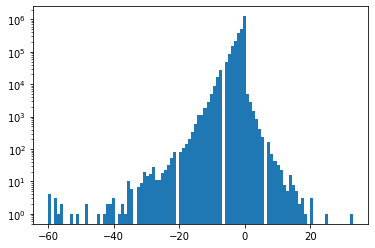

In [39]:
_ = plt.hist(raw['lapse'], bins=100, log=True)
raw['lapse'].mean(), raw['lapse'].std()

(6.112431088024829, 2.782527763092957)

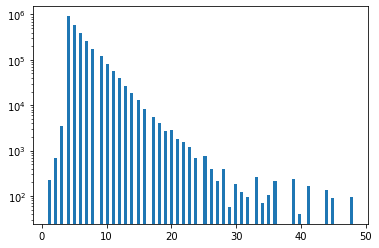

In [41]:
_ = plt.hist(raw['N'], bins=100, log=True)
raw['N'].mean(), raw['N'].std()

In [42]:
raw['N'] = raw['N'] - raw['N'].mean()
raw['N'] /= 3

(-2.502308603975272e-16, 0.3366646944487058)

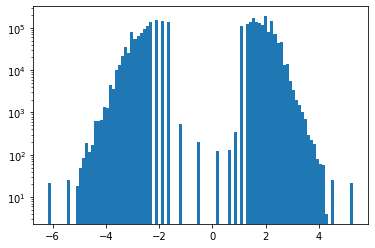

In [44]:
_ = plt.hist(raw['trip_length'], bins=100, log=True)
raw['trip_length'].mean(), raw['length'].std()

(0.9421659416330279, 0.3366646944487058)

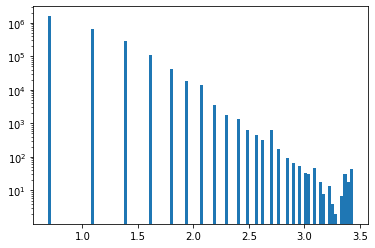

In [45]:
_ = plt.hist(raw['length'], bins=100, log=True)
raw['length'].mean(), raw['length'].std()

In [46]:
raw['log_icount'] = cupy.log1p(raw['icount'])
raw['log_dcount'] = cupy.log1p(raw['dcount'])

(1.0630507964633789, 0.6584902605051619)

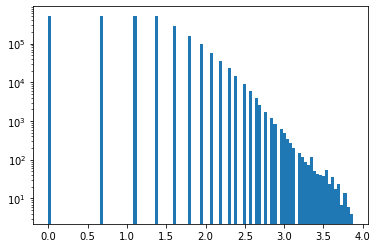

In [47]:
_ = plt.hist(raw['log_icount'], bins=100, log=True)
raw['log_icount'].mean(), raw['log_icount'].std()

(1.0630507964633786, 0.6584902605051619)

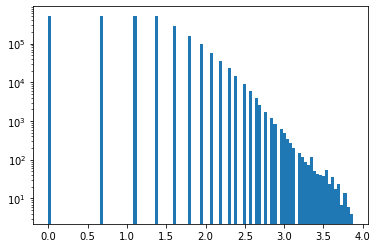

In [48]:
_ = plt.hist(raw['log_dcount'], bins=100, log=True)
raw['log_dcount'].mean(), raw['log_dcount'].std()

In [49]:
raw['mn'].unique()

array([ 8,  4,  6,  7,  9, 10, 12,  2, 11,  5,  3,  1])

In [50]:
raw['dy1'].unique()

array([5, 6, 1, 3, 0, 2, 4])

In [51]:
raw['dy2'].unique()

array([6, 1, 3, 0, 5, 2, 4])

In [52]:
class BookingDataset(Dataset):
    def __init__(self,
                 data,
                 target=None,
                ):
        super(BookingDataset, self).__init__()
        self.lag_cities_ = data[lag_cities].values
        self.mn = data['mn'].values - 1
        self.dy1 = data['dy1'].values
        self.dy2 = data['dy2'].values
        self.length = data['length'].values
        self.trip_length = data['trip_length'].values
        self.N = data['N'].values
        self.log_icount = data['log_icount'].values
        self.log_dcount = data['log_dcount'].values
        self.lag_countries_ = data[lag_countries].values
        self.first_city = data['first_city'].values
        self.first_country = data['first_country'].values
        self.booker_country_ = data['booker_country_'].values
        self.device_class_ = data['device_class_'].values
        self.lapse = data['lapse'].values
        self.season = data['season'].values
        self.weekend = data['weekend'].values
        if target is None:
            self.target = None
        else:
            self.target = data[target].values
        
    def __len__(self):
        return len(self.lag_cities_)
        
    def __getitem__(self, idx: int):
        input_dict = {
            'lag_cities_': torch.tensor(self.lag_cities_[idx], dtype=torch.long),
            'mn': torch.tensor([self.mn[idx]], dtype=torch.long),
            'dy1': torch.tensor([self.dy1[idx]], dtype=torch.long),
            'dy2': torch.tensor([self.dy2[idx]], dtype=torch.long),
            'length': torch.tensor([self.length[idx]], dtype=torch.float),
            'trip_length': torch.tensor([self.trip_length[idx]], dtype=torch.float),
            'N': torch.tensor([self.N[idx]], dtype=torch.float),
            'log_icount': torch.tensor([self.log_icount[idx]], dtype=torch.float),
            'log_dcount': torch.tensor([self.log_dcount[idx]], dtype=torch.float),
            'lag_countries_': torch.tensor(self.lag_countries_[idx], dtype=torch.long),
            'first_city': torch.tensor([self.first_city[idx]], dtype=torch.long),
            'first_country': torch.tensor([self.first_country[idx]], dtype=torch.long),
            'booker_country_': torch.tensor([self.booker_country_[idx]], dtype=torch.long),
            'device_class_': torch.tensor([self.device_class_[idx]], dtype=torch.long),
            'lapse': torch.tensor([self.lapse[idx]], dtype=torch.float),
            'season': torch.tensor([self.season[idx]], dtype=torch.long),
            'weekend': torch.tensor([self.weekend[idx]], dtype=torch.long),
        }
        if self.target is not None:
            input_dict['target'] = torch.tensor([self.target[idx]], dtype=torch.long)
        return input_dict

In [54]:
dataset = BookingDataset(raw, 'city_id_')

dataset.__getitem__(3)

{'lag_cities_': tensor([    2,     1,     0, 11158, 11158]),
 'mn': tensor([7]),
 'dy1': tensor([3]),
 'dy2': tensor([6]),
 'length': tensor([1.3863]),
 'trip_length': tensor([1.6905]),
 'N': tensor([-0.7041]),
 'log_icount': tensor([0.]),
 'log_dcount': tensor([1.3863]),
 'lag_countries_': tensor([  0,   0,   0, 195, 195]),
 'first_city': tensor([0]),
 'first_country': tensor([0]),
 'booker_country_': tensor([0]),
 'device_class_': tensor([0]),
 'lapse': tensor([0.]),
 'season': tensor([2]),
 'weekend': tensor([0]),
 'target': tensor([3])}

In [55]:
def train_epoch(loader, model, optimizer, scheduler, scaler, device):

    model.train()
    model.zero_grad()
    train_loss = []
    bar = tqdm(range(len(loader)))
    load_iter = iter(loader)
    batch = load_iter.next()
    batch = {k:batch[k].to(device, non_blocking=True) for k in batch.keys() }
    
    for i in bar:
        
        old_batch = batch
        if i + 1 < len(loader):
            batch = load_iter.next()
            batch = {k:batch[k].to(device, non_blocking=True) for k in batch.keys() }
                    

        out_dict = model(old_batch)
        logits = out_dict['logits']
        loss = out_dict['loss']              
        loss_np = loss.detach().cpu().numpy()
        
        loss.backward()

        optimizer.step()
        scheduler.step()
        for p in model.parameters(): 
            p.grad = None

        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, model, device):

    model.eval()
    val_loss = []
    LOGITS = []
    TARGETS = []
       
    with torch.no_grad():
        bar = tqdm(range(len(loader)))
        load_iter = iter(loader)
        batch = load_iter.next()
        batch = {k:batch[k].to(device, non_blocking=True) for k in batch.keys() }


        for i in bar:

            old_batch = batch
            if i + 1 < len(loader):
                batch = load_iter.next()
                batch = {k:batch[k].to(device, non_blocking=True) for k in batch.keys() }

            out_dict = model(old_batch)
            logits = out_dict['logits']
            loss = out_dict['loss']              
            loss_np = loss.detach().cpu().numpy()
            target = old_batch['target']
            LOGITS.append(logits.detach())
            TARGETS.append(target.detach())
            val_loss.append(loss_np) 

            smooth_loss = sum(val_loss[-100:]) / min(len(val_loss), 100)
            bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))

        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    
    return val_loss, LOGITS, TARGETS
        

In [56]:
def save_checkpoint(model, optimizer, scheduler, scaler, best_score, fold, seed, fname):
    checkpoint = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'scaler': scaler.state_dict(),
            'epoch': epoch,
            'best_score': best_score,
        }
    torch.save(checkpoint, './checkpoints/%s/%s_%d_%d.pt' % (fname, fname, fold, seed))

In [57]:
def load_checkpoint(fold, seed, device, fname):
    model = Net(NUM_CITIES+1, NUM_HOTELS+1, EMBEDDING_DIM, HIDDEN_DIM, dropout_rate=DROPOUT_RATE,
                loss=False).to(device)
 
    checkpoint = torch.load('./checkpoints/%s/%s_%d_%d.pt' % (fname, fname, fold, seed))
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model

In [58]:
loss_fct = torch.nn.CrossEntropyLoss(ignore_index=LOW_CITY)

class Net(nn.Module):

    def __init__(self, num_cities, num_countries, embedding_dim, hidden_dim, dropout_rate, loss=True):
        super(Net, self).__init__()
        self.loss = loss
        self.dropout_rate = dropout_rate
        
        self.cities_embeddings = nn.Embedding(num_cities, embedding_dim)     
        self.cities_embeddings.weight.data.normal_(0., 0.01)
        print('city embedding data shape', self.cities_embeddings.weight.shape)

        self.countries_embeddings = nn.Embedding(num_countries, embedding_dim)     
        self.countries_embeddings.weight.data.normal_(0., 0.01)
        print('country embedding data shape', self.countries_embeddings.weight.shape)

        self.mn_embeddings = nn.Embedding(12, embedding_dim)     
        self.mn_embeddings.weight.data.normal_(0., 0.01)

        self.dy1_embeddings = nn.Embedding(7, embedding_dim)     
        self.dy1_embeddings.weight.data.normal_(0., 0.01)

        self.dy2_embeddings = nn.Embedding(7, embedding_dim)     
        self.dy2_embeddings.weight.data.normal_(0., 0.01)
        
        #self.season_embeddings = nn.Embedding(7, embedding_dim)     
        #self.season_embeddings.weight.data.normal_(0., 0.01)
        
        self.weekend_embeddings = nn.Embedding(2, embedding_dim)     
        self.weekend_embeddings.weight.data.normal_(0., 0.01)
        
        self.linear_length = nn.Linear(1, embedding_dim, bias=False)
        self.norm_length = nn.BatchNorm1d(embedding_dim)
        self.activate_length = nn.ReLU()
        
        self.linear_trip_length = nn.Linear(1, embedding_dim, bias=False)
        self.norm_trip_length = nn.BatchNorm1d(embedding_dim)
        self.activate_trip_length = nn.ReLU()

        self.linear_N = nn.Linear(1, embedding_dim, bias=False)
        self.norm_N = nn.BatchNorm1d(embedding_dim)
        self.activate_N = nn.ReLU()

        self.linear_log_icount = nn.Linear(1, embedding_dim, bias=False)
        self.norm_log_icount = nn.BatchNorm1d(embedding_dim)
        self.activate_log_icount = nn.ReLU()

        self.linear_log_dcount = nn.Linear(1, embedding_dim, bias=False)
        self.norm_log_dcount = nn.BatchNorm1d(embedding_dim)
        self.activate_log_dcount = nn.ReLU()

        self.devices_embeddings = nn.Embedding(NUM_DEVICE, embedding_dim)     
        self.devices_embeddings.weight.data.normal_(0., 0.01)
        print('device_embeddings data shape', self.devices_embeddings.weight.shape)

        self.linear_lapse = nn.Linear(1, embedding_dim, bias=False)
        self.norm_lapse = nn.BatchNorm1d(embedding_dim)
        self.activate_lapse = nn.ReLU()
        
        self.linear1 = nn.Linear((len(lag_cities) + len(lag_countries) + 1)*embedding_dim, hidden_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.activate1 = nn.PReLU()
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.activate2 = nn.PReLU()
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.linear3 = nn.Linear(hidden_dim, embedding_dim)
        self.norm3 = nn.BatchNorm1d(embedding_dim)
        self.activate3 = nn.PReLU()
        self.dropout3 = nn.Dropout(self.dropout_rate)
        self.output_layer_bias = nn.Parameter(torch.Tensor(num_cities, ))
        self.output_layer_bias.data.normal_(0., 0.01)
        
    def get_embed(self, x, embed):
        bs = x.shape[0]
        x = embed(x)      
        # lag_embed.shape: bs, x.shape[1], embedding_dim
        x = x.view(bs, -1)
        return x

    def forward(self, input_dict):
        lag_embed = self.get_embed(input_dict['lag_cities_'], self.cities_embeddings)      
        lag_countries_embed = self.get_embed(input_dict['lag_countries_'], self.countries_embeddings)      
        mn_embed = self.get_embed(input_dict['mn'], self.mn_embeddings)      
        dy1_embed = self.get_embed(input_dict['dy1'], self.dy1_embeddings)      
        dy2_embed = self.get_embed(input_dict['dy2'], self.dy2_embeddings)  
        #season_embed = self.get_embed(input_dict['season'], self.season_embeddings)  
        weekend_embed = self.get_embed(input_dict['weekend'], self.weekend_embeddings)  
        length = input_dict['length']
        length_embed = self.activate_length(self.norm_length(self.linear_length(length)))
        trip_length = input_dict['trip_length']
        trip_length_embed = self.activate_trip_length(self.norm_trip_length(self.linear_trip_length(trip_length)))
        N = input_dict['N']
        N_embed = self.activate_N(self.norm_N(self.linear_N(N)))
        lapse = input_dict['lapse']
        lapse_embed = self.activate_lapse(self.norm_lapse(self.linear_lapse(lapse)))
        log_icount = input_dict['log_icount']
        log_icount_embed = self.activate_log_icount(self.norm_log_icount(self.linear_log_icount(log_icount)))
        log_dcount = input_dict['length']
        log_dcount_embed = self.activate_log_dcount(self.norm_log_dcount(self.linear_log_dcount(log_dcount)))
        first_city_embed = self.get_embed(input_dict['first_city'], self.cities_embeddings)  
        first_country_embed = self.get_embed(input_dict['first_country'], self.countries_embeddings)  
        booker_country_embed = self.get_embed(input_dict['booker_country_'], self.countries_embeddings)  
        device_embed = self.get_embed(input_dict['device_class_'], self.devices_embeddings)  
        x = (mn_embed + dy1_embed + dy2_embed + length_embed + log_icount_embed + log_dcount_embed \
             + first_city_embed + first_country_embed + booker_country_embed + device_embed \
             + trip_length_embed + N_embed + lapse_embed + weekend_embed)
        x = torch.cat([lag_embed, lag_countries_embed, x], -1)
        x = self.activate1(self.norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = x + self.activate2(self.norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = self.activate3(self.norm3(self.linear3(x)))
        x = self.dropout3(x)
        logits = F.linear(x, self.cities_embeddings.weight, bias=self.output_layer_bias)
        output_dict = {
            'logits':logits
                      }
        if self.loss:
            target = input_dict['target'].squeeze(1)
            #print(logits.shape, target.shape)
            loss = loss_fct(logits, target)
            output_dict['loss'] = loss
        return output_dict


In [63]:
TRAIN_BATCH_SIZE = 1024
WORKERS = 8
LR = 1e-3
EPOCHS = 12
GRADIENT_ACCUMULATION = 1
EMBEDDING_DIM = 64
HIDDEN_DIM =  1024
DROPOUT_RATE = 0.2
device = torch.device('cpu')

In [60]:
def get_top4(preds):
    TOP4 = np.empty((preds.shape[0], 4))
    for i in range(4):
        x = np.argmax(preds, axis=1)
        TOP4[:,i] = x
        x = np.expand_dims(x, axis=1)
        np.put_along_axis(preds, x, -1e10, axis=1)
    return TOP4

def top4(preds, target):
    TOP4 = get_top4(preds)
    acc = np.max(TOP4 == target, axis=1)
    acc = np.mean(acc)
    return acc

In [ ]:
TRAIN_WITH_TEST = True

seed = 0
seed_torch(seed)

preds_all = []
best_scores = []
best_epochs = []
for fold in range(5):

    seed_torch(seed)
    preds_fold = []
    print('#'*25)
    print('### FOLD %i'%(fold))
    if TRAIN_WITH_TEST:
        train = raw.loc[ (raw.fold!=fold)&(raw.dcount>0)&(raw.istest==0)|( (raw.istest==1)&(raw.icount>0) ) ].copy()
    else:
        train = raw.loc[ (raw.fold!=fold)&(raw.dcount>0)&(raw.istest==0) ].copy()
    valid = raw.loc[ (raw.fold==fold)&(raw.istest==0)&(raw.icount==0) &(raw.reverse == 0)].copy()
    print(train.shape, valid.shape)

    train_dataset = BookingDataset(train, target='city_id_')

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=WORKERS,
        shuffle=True,
        pin_memory=True,
    )

    valid_dataset = BookingDataset(valid, target='city_id_')

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=WORKERS,
        shuffle=False,
        pin_memory=True,
    )
    

    model = Net(NUM_CITIES+1, NUM_HOTELS+1, EMBEDDING_DIM, HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
                                              pct_start=0.1, 
                                              div_factor=1e3, 
                                              max_lr=3e-3, 
                                              epochs=EPOCHS, 
                                              steps_per_epoch=int(np.ceil(len(train_data_loader)/GRADIENT_ACCUMULATION)))
    scaler = GradScaler()

    best_score = 0
    best_epoch = 0

    for epoch in range(EPOCHS):
        print(time.ctime(), 'Epoch:', epoch, flush=True)
        train_loss = train_epoch(train_data_loader, model, optimizer, scheduler, scaler, device)
        val_loss, PREDS, TARGETS = val_epoch(valid_data_loader, model, device) 
        PREDS[:, LOW_CITY] = -1e10# remove low frequency cities
        score = top4(PREDS, TARGETS)

        content = 'Fold %d Seed %d Ep %d lr %.7f train loss %4f val loss %4f score %4f'
        print(content % (fold, seed, epoch, 
                         optimizer.param_groups[0]["lr"],
                         np.mean(train_loss),
                         np.mean(val_loss),
                         score,
                        ), 
              flush=True)
        if score > best_score:
            best_score = score
            best_epoch = epoch
            preds_fold = PREDS
            save_checkpoint(model, optimizer, scaler, scheduler, best_score, fold, seed, fname)
    del model, scaler, scheduler, optimizer, valid_data_loader, valid_dataset, train_data_loader, train_dataset
    gc.collect()

    preds_all.append(preds_fold)
    print('fold %d, best score: %0.6f best epoch: %3d' % (fold, best_score, best_epoch))
    best_scores.append(best_score)
    best_epochs.append(best_epoch)
    #with open('../checkpoints/%s/%s_%d_preds.pkl' % (fname, fname, seed), 'wb') as file:
    #    pkl.dump(preds_all, file)
        
    #break
print()
for fold, (best_score, best_epoch) in enumerate(zip(best_scores, best_epochs)):
    print('fold %d, best score: %0.6f best epoch: %3d' % (fold, best_score, best_epoch))
print('seed %d best score: %0.6f best epoch: %0.1f' % (seed, np.mean(best_scores), np.mean(best_epochs)))

#########################
### FOLD 0
(1826251, 51) (43552, 51)
city embedding data shape torch.Size([11159, 64])
country embedding data shape torch.Size([196, 64])
device_embeddings data shape torch.Size([3, 64])
Sat Jun 12 01:01:31 2021 Epoch: 0


/tmp/.local/lib/python3.6/site-packages/torch/cuda/amp/grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
loss: 8.78003, smth: 9.02039:  19%|█▉        | 345/1784 [01:35<05:25,  4.42it/s]

In [ ]:
def test_epoch(loader, models, device):

    #model.eval()
    PREDS = []
    
    with torch.no_grad():
        if 1:
            bar = tqdm(range(len(loader)))
            load_iter = iter(loader)
            batch = load_iter.next()
            batch = {k:batch[k].to(device, non_blocking=True) for k in batch.keys() }

            for i in bar:
                old_batch = batch
                if i + 1 < len(loader):
                    batch = load_iter.next()
                    batch = {k:batch[k].to(device, non_blocking=True) for k in batch.keys() }
                    
                preds = 0
                for model in models:
                    out_dict = model(old_batch)
                    preds = preds + out_dict['logits'] / NFOLDS
                PREDS.append(preds.detach())
                
    
    PREDS = torch.cat(PREDS).cpu().numpy()
    
    return PREDS

NFOLDS = 5
seed = 0
models = [load_checkpoint(fold, seed, device, fname) for fold in range(NFOLDS)]

In [ ]:
pd.options.display.max_columns = 100

## Test N-1 (leaky as we train using all test)

In [ ]:
def acc(valid):
    acc = cupy.max(valid[COLS[1:]].values == valid[['city_id']].values, axis=1)
    acc = cupy.mean(acc)
    return acc

In [ ]:
test = raw.loc[ (raw.istest==1)&(raw.icount==1) ].copy()
print( test.shape )
test.head()

In [ ]:
test_dataset = BookingDataset(test.to_pandas(), target=None)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=WORKERS,
    shuffle=False,
    pin_memory=True,
)

PREDS = test_epoch(test_data_loader, models, device) 
PREDS[:, LOW_CITY] = -1e10# remove low frequency cities
TOP4 = get_top4(PREDS).astype('int')
TOP4.shape

COLS = ['utrip_id']

In [ ]:
city_mapping = MAPS[0].reset_index()

In [ ]:
CITY_MAP = MAPS[0].astype('int')
for k in range(4):
    test['city_id_%i'%(k+1)] = TOP4[:,k]
    tmp = test[['city_id_%i'%(k+1)]].astype('int32').copy()
    tmp['sorting'] = cupy.asarray(range(tmp.shape[0]))
    tmp = tmp.merge(city_mapping, how='left', left_on='city_id_%i'%(k+1), right_on='index')
    tmp = tmp.sort_values('sorting')
    test['city_id_%i'%(k+1)] = tmp['city_id'].astype('int32').values.copy()
    COLS.append('city_id_%i'%(k+1))
    
test[COLS].head()

In [ ]:
test.head()

In [ ]:
acc(test)

## Test submission

In [ ]:
test = raw.loc[ (raw.istest==1)&(raw.icount==0)&(raw.reverse==0) ].copy()
print( test.shape )
test.head()

In [ ]:
test_dataset = BookingDataset(test.to_pandas(), target=None)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=WORKERS,
    shuffle=False,
    pin_memory=True,
)

PREDS = test_epoch(test_data_loader, models, device) 
PREDS[:, LOW_CITY] = -1e10# remove low frequency cities
TOP4 = get_top4(PREDS).astype('int')
TOP4.shape

COLS = ['utrip_id']
CITY_MAP = MAPS[0].astype('int')
for k in range(4):
    test['city_id_%i'%(k+1)] = TOP4[:,k]
    tmp = test[['city_id_%i'%(k+1)]].astype('int32').copy()
    tmp['sorting'] = cupy.asarray(range(tmp.shape[0]))
    tmp = tmp.merge(city_mapping, how='left', left_on='city_id_%i'%(k+1), right_on='index')
    tmp = tmp.sort_values('sorting')
    test['city_id_%i'%(k+1)] = tmp['city_id'].astype('int32').values.copy()
    COLS.append('city_id_%i'%(k+1))
    
test[COLS].head()

In [ ]:
test[COLS].to_csv('%s_sub.csv' % fname, index=False)

## OOF Prediction

In [ ]:
def load_checkpoint(fold, seed, device, fname, loss=False):
    model = Net(NUM_CITIES+1, NUM_HOTELS+1, EMBEDDING_DIM, HIDDEN_DIM, dropout_rate=DROPOUT_RATE,
                loss=loss).to(device)
 
    checkpoint = torch.load('./checkpoints/%s/%s_%d_%d.pt' % (fname, fname, fold, seed))
    model.load_state_dict(checkpoint['model'])
    model.eval()
    return model

def get_topN(preds, N):
    TOPN = np.empty((preds.shape[0], N))
    PREDN = np.empty((preds.shape[0], N))
    preds = preds.copy()
    for i in tqdm(range(N)):
        x = np.argmax(preds, axis=1)
        TOPN[:,i] = x
        x = np.expand_dims(x, axis=1)
        PREDN[:,i] = np.take_along_axis(preds, x, axis=1).ravel()
        np.put_along_axis(preds, x, -1e10, axis=1)
    return TOPN, PREDN

def get_top4(preds):
    preds = preds.copy()
    TOP4 = np.empty((preds.shape[0], 4))
    for i in range(4):
        x = np.argmax(preds, axis=1)
        TOP4[:,i] = x
        x = np.expand_dims(x, axis=1)
        np.put_along_axis(preds, x, -1e10, axis=1)
    return TOP4

def top4(preds, target):
    TOP4 = get_top4(preds)
    acc = np.max(TOP4 == target, axis=1)
    acc = np.mean(acc)
    return acc

TRAIN_WITH_TEST = True

seed = 0
seed_torch(seed)

preds_all = []
test_preds_all = []
train_all = []
best_scores = []
for fold in range(1):

    seed_torch(seed)
    preds_fold = []
    print('#'*25)
    print('### FOLD %i'%(fold))
    valid = raw.loc[ (raw.fold==fold)&(raw.istest==0)&(raw.icount==0) &(raw.reverse == 0)].copy()
    print(valid.shape)

    valid_dataset = BookingDataset(valid.to_pandas(), target='city_id_')

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=WORKERS,
        shuffle=False,
        pin_memory=True,
    )
    
    test_dataset = BookingDataset(test.to_pandas(), target=None)

    test_data_loader = DataLoader(
        test_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=WORKERS,
        shuffle=False,
        pin_memory=True,
    )

    
    model = load_checkpoint(fold, seed, device, fname, loss=True)
    val_loss, PREDS, TARGETS = val_epoch(valid_data_loader, model, device) 
    PREDS[:, LOW_CITY] = -1e10# remove low frequency cities
    score = top4(PREDS, TARGETS)
    print('fold %d, best score: %0.6f' % (fold, score))
    score = top4(PREDS, valid[['city_id_']].to_pandas().values)
    print('fold %d, best score: %0.6f' % (fold, score))
    best_scores.append(score)
    preds_all.append(PREDS)
    train_all.append(valid.to_pandas())

    model = load_checkpoint(fold, seed, device, fname, loss=False)
    TEST_PREDS = test_epoch(test_data_loader, [model], device) 
    TEST_PREDS[:, LOW_CITY] = -1e10# remove low frequency cities
    test_preds_all.append(TEST_PREDS)
print('seed %d best score: %0.6f' % (seed, np.mean(best_scores)))

preds_all = np.concatenate(preds_all)
print('vaid pred shape', preds_all.shape)

test_preds_all = np.mean(test_preds_all, axis=0)
print('test pred shape', test_preds_all.shape)

top_preds, top_logits = get_topN(preds_all, 4)
targets = np.concatenate([valid[['city_id_']].values for valid in train_all])
valid_trips = np.concatenate([valid[['utrip_id']].values for valid in train_all])

print('CV score', np.mean(np.max(top_preds == targets, axis=1)))

valid_trips

top_preds, top_logits = get_topN(preds_all, 50)
top_test_preds, top_test_logits = get_topN(test_preds_all, 50)


top_preds.shape, top_logits.shape, top_test_preds.shape, top_test_logits.shape

valid_cities = np.concatenate([valid[['city_id']].values for valid in train_all])
oof = {
    'valid_trips':valid_trips,
    'top_preds':top_preds,
    'top_logits':top_logits,
    'top_test_preds':top_test_preds,
    'top_test_logits':top_test_logits,
    'city_map':CITY_MAP,
    'valid_cities':valid_cities,
}

with open((checkpoint_path / (fname + '_oof.pkl')), 'wb') as file:
    pkl.dump(oof, file)
    
print('done')


In [ ]:
oof = {
    'valid_trips':valid_trips,
    'top_preds':top_preds,
    'top_logits':top_logits,
    'top_test_preds':top_test_preds,
    'top_test_logits':top_test_logits,
    'city_map':CITY_MAP,
    'valid_cities':valid_cities,
    'preds_all':preds_all,
    'test_preds_all':test_preds_all,
}

with open((checkpoint_path / (fname + '_oof.pkl')), 'wb') as file:
    pkl.dump(oof, file, protocol=pkl.HIGHEST_PROTOCOL)
    
print('done')